**Note**: many of the jupyter notebooks provided here have SVG figures as cell outputs, which will only be displayed by JupyterLab or Jupyter Notebook if the notebook is marked as **trusted** (In JupyterLab: Ctrl+Shift+C -> Trust Notebook).

# Data Input

There are 3 alternatives to import wind farm layout data for use within **optiwindnet**:
- optiwindnet API
- `.yaml` file
- `.osm.pbf` file

In [1]:
from optiwindnet.svg import svgplot

## Option 0: Use the optiwindnet API from Python

In [2]:
from optiwindnet.importer import L_from_site

In [3]:
from itertools import pairwise

In [4]:
import numpy as np

In [5]:
# all coordinates are sequences of (x, y) pairs
# if input coordinates are in arrays X and Y, use `np.hstack((X, Y))`
border = np.array( # coordinate sequence defines the polygon, last-first segment implicit
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)
# 'obstacles' is an optional location attribute
obstacles = [
    # - obstacles must be strictly inside the border polygon
    # - undefined behavior if obstacles and border overlap
    # first obstacle
    np.array([[1540, 920], [1600, 940], [1600, 1150], [1400, 1200]]),
    # [second obstacle] ...
]
substations = np.array([[696, 1063],], dtype=float)
turbines = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)
R = substations.shape[0]
T = turbines.shape[0]
border_sizes = np.array([border.shape[0]] +
                        [obstacle.shape[0] for obstacle in obstacles])
B = border_sizes.sum()
obstacle_idxs = np.cumsum(border_sizes) + T

L = L_from_site(
    R=R, T=T, B=B,
    border=np.arange(T, T + border.shape[0]),
    obstacles=[np.arange(a, b) for a, b in pairwise(obstacle_idxs)],
    name='Example Location',
    handle='example',
    VertexC=np.vstack((turbines, border, *obstacles, substations)),
)

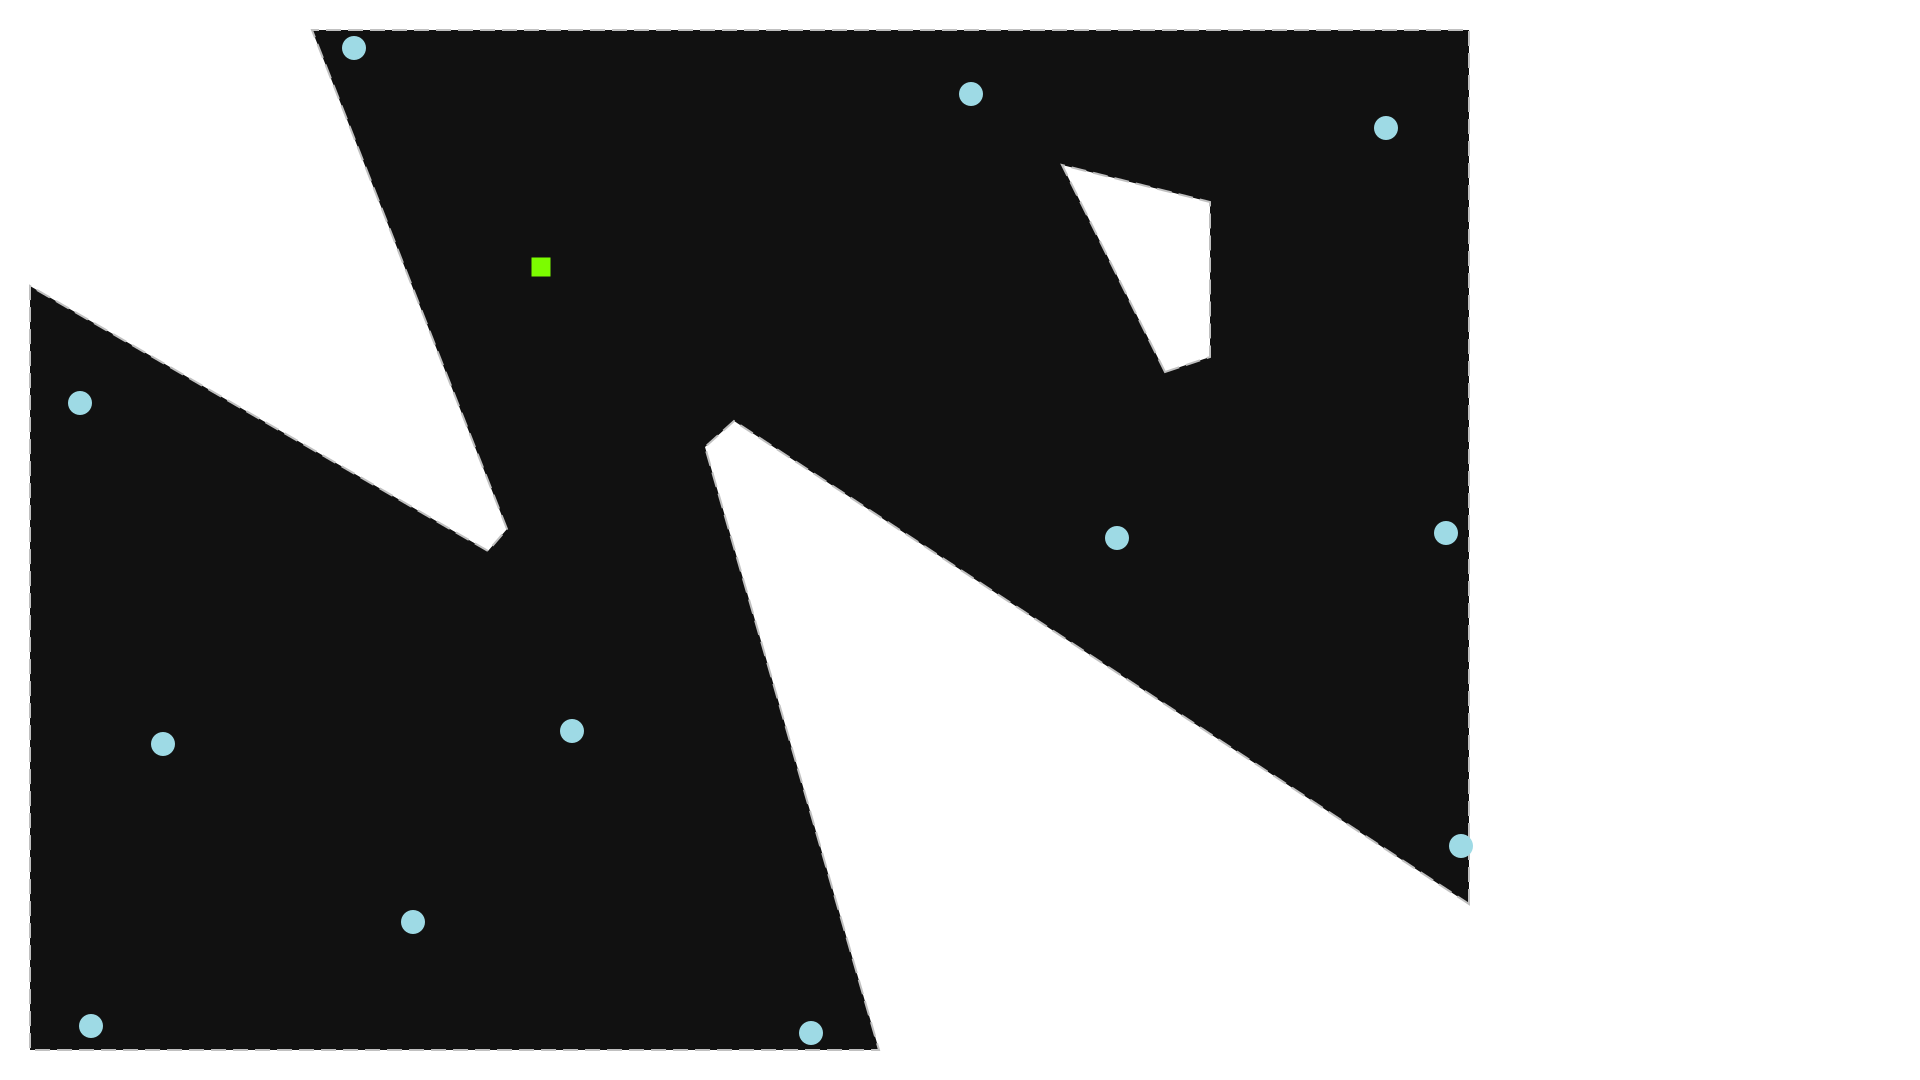

In [6]:
svgplot(L)

## Option 1: YAML input file

In [7]:
from optiwindnet.importer import L_from_yaml

In [8]:
with open('data/example_location.yaml', 'w') as yaml_file:
    yaml_file.write('''
# coordinate format can be "planar" or "latlon"
#   - for "latlon" examples, see `optiwindnet/data/*.yaml`
#   - this field is optional, default is "latlon"
#   - coordinates are converted to floats, so floats may be used as well
COORDINATE_FORMAT: planar

# extents define a polygon:
#   - do not repeat the initial vertex at the end
#   - line breaks are optional
EXTENTS: [
  [1951, 200],
  [1951, 1383],
  [386, 1383],
  [650, 708],
  [624, 678],
  [4, 1036],
  [4, 3],
  [1152, 3],
  [917, 819],
  [957, 854]
]

# obstacles is optional and must be a list of polygons (even if 1 obstacle)
#   - obstacles must be strictly inside the extents polygon
#   - the parser will not complain about borders of obstacles overlapping
#     borders of extents, but optiwindnet will behave unpredictably
OBSTACLES: [
  [  # first obstacle
    [1540, 920],
    [1600, 940],
    [1600, 1150],
    [1400, 1200],
  ],
  # [second obstacle]
]

SUBSTATIONS: [
  [696, 1063],
]

TURBINES: [
  [1940, 279],
  [1920, 703],
  [1475, 696],
  [1839, 1250],
  [1277, 1296],
  [442, 1359],
  [737, 435],
  [1060, 26],
  [522, 176],
  [87, 35],
  [184, 417],
  [71, 878],
]
''')

In [9]:
L = L_from_yaml('data/example_location.yaml')

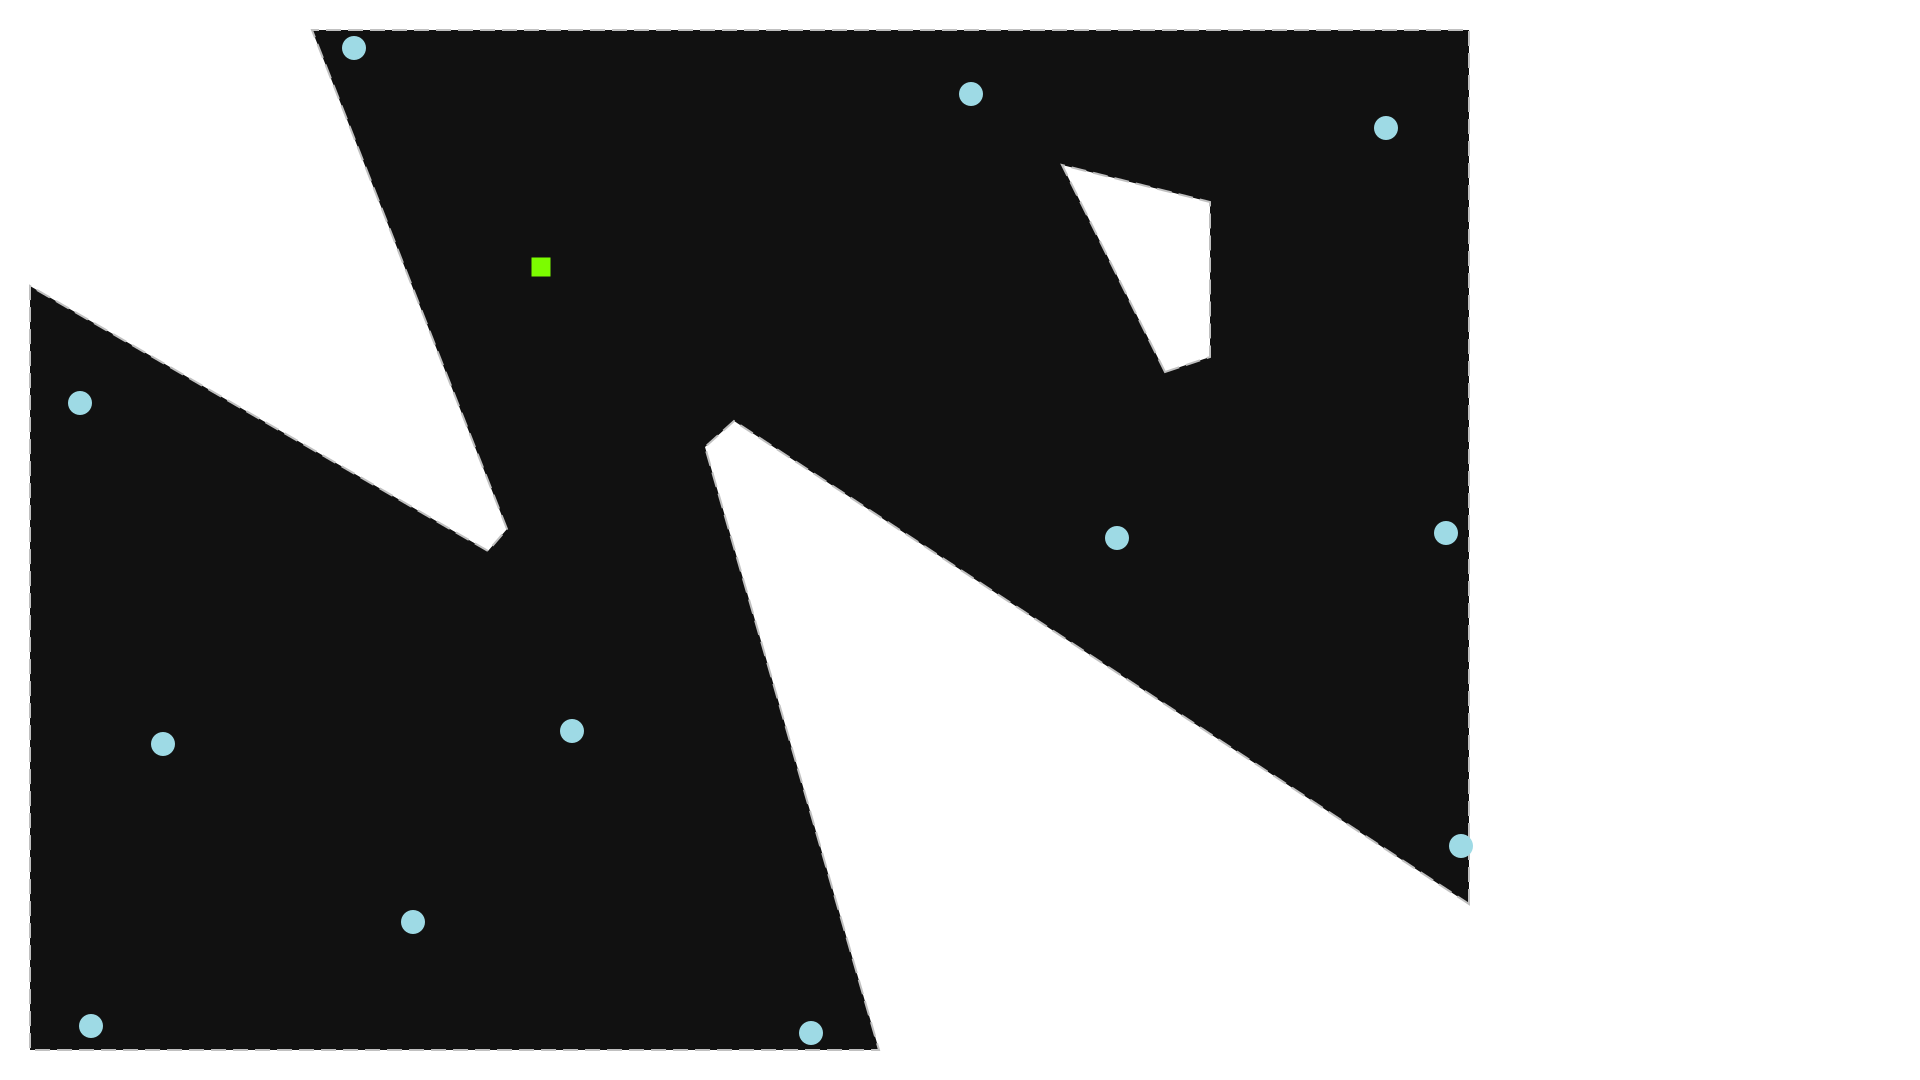

In [10]:
svgplot(L)

## Option 2: OSM.PBF input file (aka OpenStreetMap protobuffer format)

The JOSM open-source map editor is recommended if using this format: <https://josm.openstreetmap.de/>. In addition, the JOSM plugin **pbf** is required to save in the `.osm.pbf` format. The plugin **opendata** is useful for importing many common GIS file formats.

The OpenStreetMaps objects used for representing a windfarm location are:
- *nodes*
- *ways*
- *multipolygons* (relation between closed ways)

Wind turbines are represented by *nodes* with the tag `power=generator`. Substations are represented either by *nodes* or by closed *ways* tagged `power=substation` or `power=transformer`. Substations based on *ways* will be reduced to the point at the centroid of the polygon defined by the *way*.

The border of the windfarm can be a closed *way* tagged `power=plant`. If obstacles are required, then the closed *way* for the border must be combined with the closed *ways* for the obstacles in a *multipolygon* with the tag `power=plant` (in which case the *ways* themselves should not be tagged).

See `optiwindnet/data/*.osm.pbf` for more examples.

In [11]:
from optiwindnet.importer import L_from_pbf

In [12]:
L = L_from_pbf('data/example_location.osm.pbf')

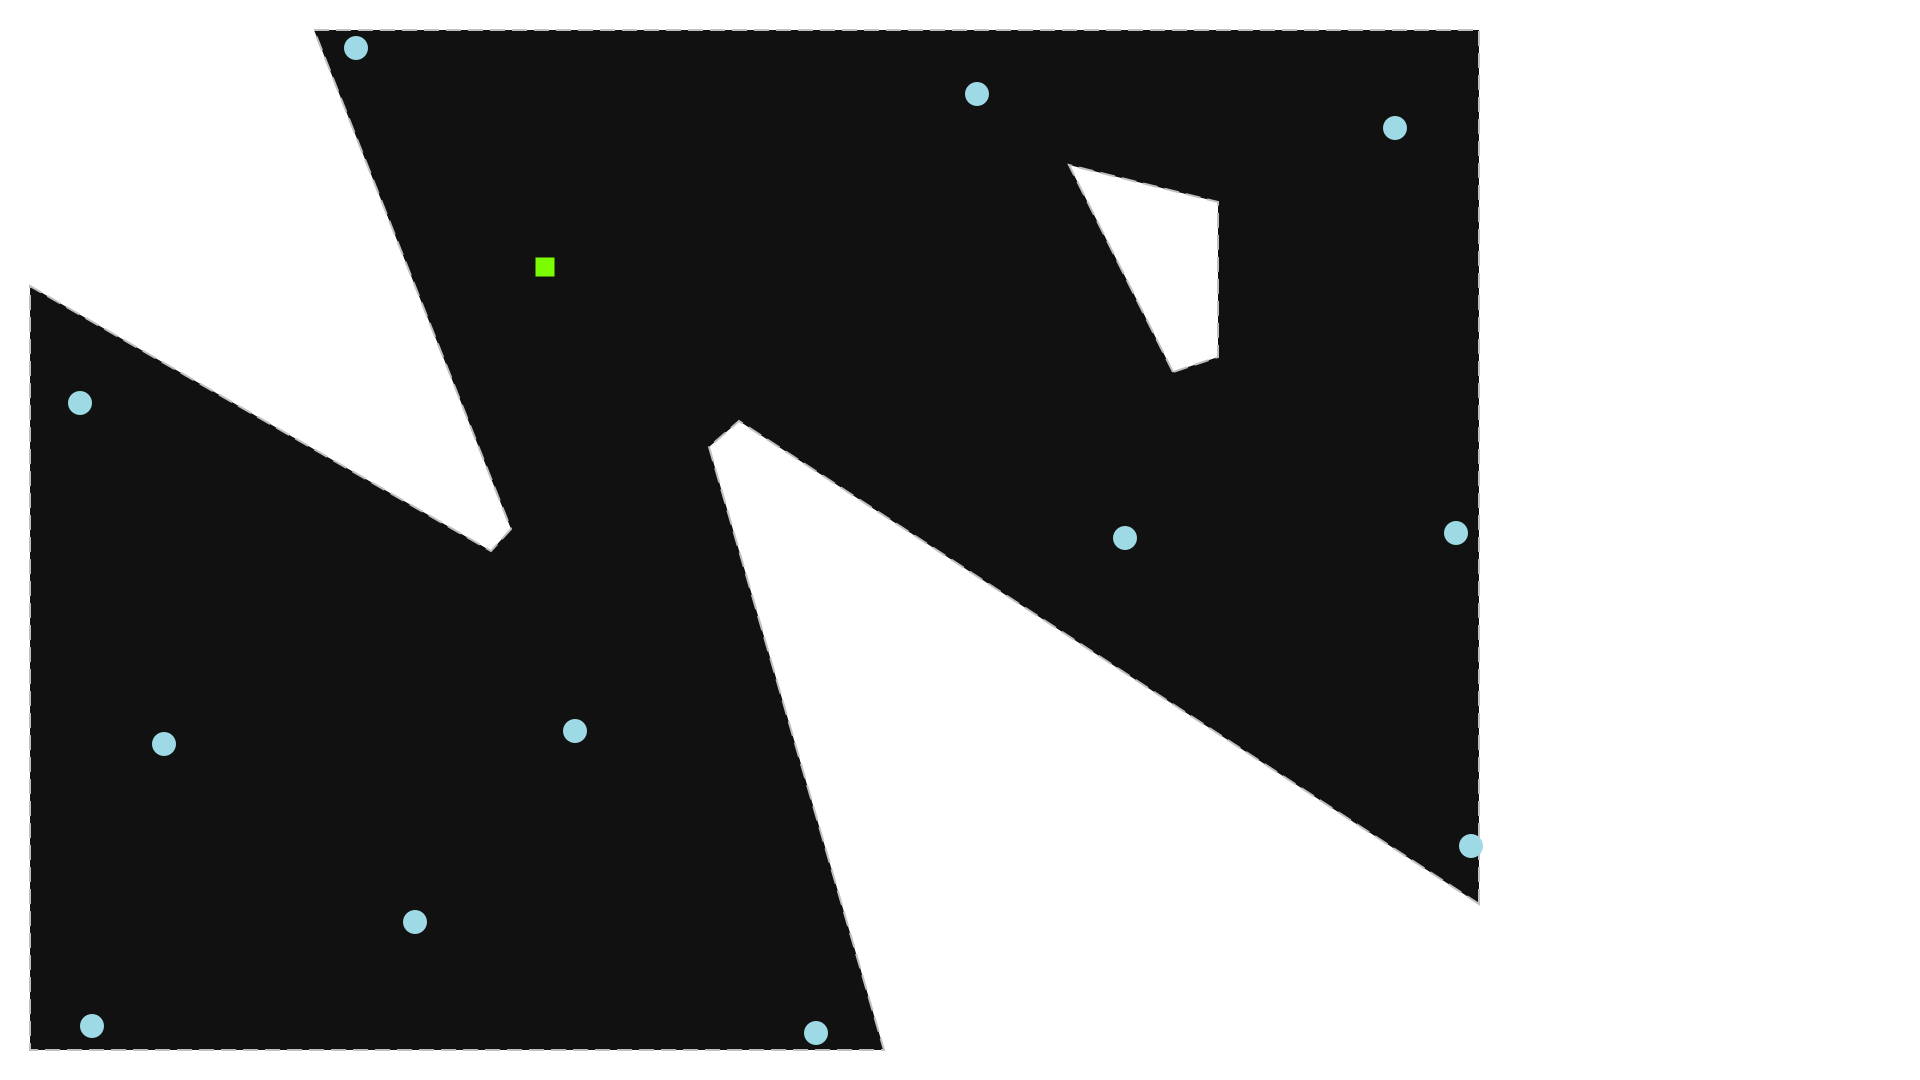

In [13]:
svgplot(L)